In [1]:
from __future__ import print_function, division, absolute_import

%load_ext autoreload
%autoreload 2

from gp_ucb import *
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from IPython.html import widgets # Widget definitions
from IPython import display # Used to display widgets in the notebook

anaconda installed and mkl is loaded


 :0: FutureWarning:IPython widgets are experimental and may change in the future.


## Define a kernel and function

Here we define a kernel. The function is drawn at random from the GP and is corrupted my Gaussian noise

In [2]:
noise_var = 0.05 ** 2

# Set fixed Gaussian measurement noise
likelihood = GPy.likelihoods.gaussian.Gaussian(variance=noise_var)
likelihood.constrain_fixed(warning=False);

# Bounds on the inputs variable
bounds = [(-5., 5.), (-5., 5.)]

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0,
                      ARD=True)

# Initial safe point
x0 = np.zeros((1, len(bounds)))

# Generate function with safe initial point at x=0
def sample_safe_fun():
    while True:
            fun = sample_gp_function(kernel, bounds, noise_var, 10)
            if fun([0,0]) > 0.5:
                break
    return fun

## Interactive run of the algorithm

The slow part of running this is the plotting with matplotlib. Consider switching to the 2D level sets.

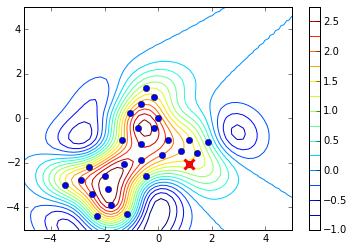

In [3]:
button_add = widgets.Button(description='Add sample', tooltip='Sample a new data point for the optimization')
button_reset = widgets.Button(description='Reset', tooltip='Restart the safe optimization algorithm')
button_new = widgets.Button(description='New function', tooltip='Add a new function and reset')
button_3d = widgets.Button(description='Toggle 2D/3D', tooltip='Toggle 2D/3D view')

plot_3d = False
def plot_gp():
    gp_ucb.plot(plot_3d=plot_3d, n_samples=50)
    
    # Plot last point red
    if gp_ucb.gp is not None:
        if plot_3d:
            pass
            plt.plot(gp_ucb.gp.X[-1, 0, None], gp_ucb.gp.X[-1, 1, None], gp_ucb.gp.Y[-1, 0, None],
                     'rx', ms=10, mew=3, label='Last Point')
        else:
            plt.plot(gp_ucb.gp.X[-1, 0], gp_ucb.gp.X[-1, 1],
                     'rx', ms=10, mew=3, label='Last Point')
        
    # plt.plot(*fun(None, return_data=True)

    # Ensure we only get one plot
    display.clear_output(wait=True)
    
def toggle_3d(b=None):
    global plot_3d
    plot_3d = not plot_3d
    plot_gp()
button_3d.on_click(toggle_3d)

def new_sample(b=None):
    """Draw a new gp sample"""
    gp_ucb.optimize()
    plot_gp()
button_add.on_click(new_sample)

def reset(b=None):
    """Reset the GP-UCB algorithm"""
    global gp_ucb
    gp = GPy.core.GP(x0, fun(x0), kernel, likelihood)
    gp_ucb = GaussianProcessSafeUCB(fun, gp, bounds, 100, 0.)
    plot_gp()
button_reset.on_click(reset)

def new_fun(b=None):
    """Draw a new function from the GP"""
    global fun
    fun = sample_safe_fun()
    reset(b)
button_new.on_click(new_fun)

display.display(button_add, button_new, button_3d, button_reset)
new_fun()